In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR + "data/"
DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'deepsig_custom_v2_iq_mp'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling2D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# I/Q samples to Module/Phase conversion

Each signal is transformed from an I/Q sample to his Module/Phase representation, and added as a column to the dataset.

In [7]:
def I_Q_to_module_phase(signal):
    modules = []
    phases =[]
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)

        modules.append(abs(cmplx))
        phases.append(cmath.phase(cmplx))

    # return [module_1, module_2, ..., module_n], [phase_1, phase_2, ..., phase_n]
    return modules, phases

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_module_phase(signal)
    
    # transformed_signal is a <modules, phases> couple
    transformed_signals.append(transformed_signal)

In [9]:
module_phase_signals_column_dataframe_name = 'MP signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[module_phase_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    module_phase_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding Module/Phase signals

In [10]:
dataset_df

,IQ signals,MP signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","([0.009777415810077348, 0.008160794610184235, ...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","([0.006428271419970337, 0.0018729896699540463,...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","([0.006714471814517775, 0.010443807990507132, ...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","([0.0036471206082490607, 0.008847963411403753,...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","([0.01363757358555227, 0.004953662955395487, 0...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","([0.007888647836121875, 0.00518580783630137, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","([0.004378196387910148, 0.006676949935829746, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","([0.013097595344676685, 0.008587072893700217, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","([0.004868425922433083, 0.01011580181134021, 0...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
signals = []

for i in range(0, len(dataset_df.index)):
    signal = []
    signal.append(dataset_df[iq_signals_column_dataframe_name][i][0])
    signal.append(dataset_df[iq_signals_column_dataframe_name][i][1])
    signal.append(dataset_df[module_phase_signals_column_dataframe_name][i][0])
    signal.append(dataset_df[module_phase_signals_column_dataframe_name][i][1])
    signals.append(signal)

labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(154000, 4, 128)
[4, 128]


In [16]:
model = neural_networks.custom_deepsig_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 4, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4, 36)             9252      
_________________________________________________________________
dense (Dense)                (None, 4, 256)            9472      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 18)             18450     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 18)             0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               9472  

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 30:31 - loss: 2.4109

  9/151 [>.............................] - ETA: 1s - loss: 2.3862   

 17/151 [==>...........................] - ETA: 0s - loss: 2.3591

 25/151 [===>..........................] - ETA: 0s - loss: 2.3361

 33/151 [=====>........................] - ETA: 0s - loss: 2.3188

 41/151 [=======>......................] - ETA: 0s - loss: 2.3048

 48/151 [========>.....................] - ETA: 0s - loss: 2.2943

 56/151 [==========>...................] - ETA: 0s - loss: 2.2835

 64/151 [===========>..................] - ETA: 0s - loss: 2.2735

 72/151 [=============>................] - ETA: 0s - loss: 2.2642

 80/151 [==============>...............] - ETA: 0s - loss: 2.2555

 88/151 [================>.............] - ETA: 0s - loss: 2.2472

 96/151 [==================>...........] - ETA: 0s - loss: 2.2394

104/151 [===================>..........] - ETA: 0s - loss: 2.2321

112/151 [=====================>........] - ETA: 0s - loss: 2.2252

120/151 [======================>.......] - ETA: 0s - loss: 2.2186

128/151 [========================>.....] - ETA: 0s - loss: 2.2123

136/151 [==========================>...] - ETA: 0s - loss: 2.2064

144/151 [===========================>..] - ETA: 0s - loss: 2.2007

151/151 [==============================] - ETA: 0s - loss: 2.1960

151/151 [==============================] - 14s 11ms/step - loss: 2.1953 - val_loss: 1.9819


Epoch 2/100
  1/151 [..............................] - ETA: 1s - loss: 1.9690

  9/151 [>.............................] - ETA: 0s - loss: 1.9761

 17/151 [==>...........................] - ETA: 0s - loss: 1.9715

 25/151 [===>..........................] - ETA: 0s - loss: 1.9695

 33/151 [=====>........................] - ETA: 0s - loss: 1.9680

 41/151 [=======>......................] - ETA: 0s - loss: 1.9662

 49/151 [========>.....................] - ETA: 0s - loss: 1.9647

 57/151 [==========>...................] - ETA: 0s - loss: 1.9638

 65/151 [===========>..................] - ETA: 0s - loss: 1.9629



 73/151 [=============>................] - ETA: 0s - loss: 1.9620

 81/151 [===============>..............] - ETA: 0s - loss: 1.9613

 89/151 [================>.............] - ETA: 0s - loss: 1.9606

 97/151 [==================>...........] - ETA: 0s - loss: 1.9599

105/151 [===================>..........] - ETA: 0s - loss: 1.9594

113/151 [=====================>........] - ETA: 0s - loss: 1.9589

121/151 [=======================>......] - ETA: 0s - loss: 1.9583

129/151 [========================>.....] - ETA: 0s - loss: 1.9578

137/151 [==========================>...] - ETA: 0s - loss: 1.9573

146/151 [============================>.] - ETA: 0s - loss: 1.9569

151/151 [==============================] - 1s 8ms/step - loss: 1.9565 - val_loss: 1.9535


Epoch 3/100
  1/151 [..............................] - ETA: 1s - loss: 1.9060

  8/151 [>.............................] - ETA: 1s - loss: 1.9222

 16/151 [==>...........................] - ETA: 0s - loss: 1.9219

 24/151 [===>..........................] - ETA: 0s - loss: 1.9206

 32/151 [=====>........................] - ETA: 0s - loss: 1.9196

 41/151 [=======>......................] - ETA: 0s - loss: 1.9184

 49/151 [========>.....................] - ETA: 0s - loss: 1.9179

 57/151 [==========>...................] - ETA: 0s - loss: 1.9172

 65/151 [===========>..................] - ETA: 0s - loss: 1.9169

 73/151 [=============>................] - ETA: 0s - loss: 1.9165

 81/151 [===============>..............] - ETA: 0s - loss: 1.9162

 89/151 [================>.............] - ETA: 0s - loss: 1.9159

 97/151 [==================>...........] - ETA: 0s - loss: 1.9156

105/151 [===================>..........] - ETA: 0s - loss: 1.9153

113/151 [=====================>........] - ETA: 0s - loss: 1.9151

121/151 [=======================>......] - ETA: 0s - loss: 1.9149

129/151 [========================>.....] - ETA: 0s - loss: 1.9148

137/151 [==========================>...] - ETA: 0s - loss: 1.9147

145/151 [===========================>..] - ETA: 0s - loss: 1.9145

151/151 [==============================] - 1s 8ms/step - loss: 1.9144 - val_loss: 1.9172


Epoch 4/100
  1/151 [..............................] - ETA: 1s - loss: 1.8938

  9/151 [>.............................] - ETA: 0s - loss: 1.8915

 17/151 [==>...........................] - ETA: 0s - loss: 1.8899

 26/151 [====>.........................] - ETA: 0s - loss: 1.8880

 34/151 [=====>........................] - ETA: 0s - loss: 1.8870

 42/151 [=======>......................] - ETA: 0s - loss: 1.8866

 50/151 [========>.....................] - ETA: 0s - loss: 1.8858

 58/151 [==========>...................] - ETA: 0s - loss: 1.8852

 66/151 [============>.................] - ETA: 0s - loss: 1.8847

 74/151 [=============>................] - ETA: 0s - loss: 1.8844

 82/151 [===============>..............] - ETA: 0s - loss: 1.8842

 90/151 [================>.............] - ETA: 0s - loss: 1.8840

 98/151 [==================>...........] - ETA: 0s - loss: 1.8838

107/151 [====================>.........] - ETA: 0s - loss: 1.8836

115/151 [=====================>........] - ETA: 0s - loss: 1.8834

123/151 [=======================>......] - ETA: 0s - loss: 1.8833

132/151 [=========================>....] - ETA: 0s - loss: 1.8831

140/151 [==========================>...] - ETA: 0s - loss: 1.8830

148/151 [============================>.] - ETA: 0s - loss: 1.8829

151/151 [==============================] - 1s 8ms/step - loss: 1.8828 - val_loss: 1.8998


Epoch 5/100
  1/151 [..............................] - ETA: 1s - loss: 1.8383

  9/151 [>.............................] - ETA: 0s - loss: 1.8340

 17/151 [==>...........................] - ETA: 0s - loss: 1.8388

 25/151 [===>..........................] - ETA: 0s - loss: 1.8408

 34/151 [=====>........................] - ETA: 0s - loss: 1.8422

 42/151 [=======>......................] - ETA: 0s - loss: 1.8429

 50/151 [========>.....................] - ETA: 0s - loss: 1.8435

 58/151 [==========>...................] - ETA: 0s - loss: 1.8443

 66/151 [============>.................] - ETA: 0s - loss: 1.8450

 74/151 [=============>................] - ETA: 0s - loss: 1.8456

 82/151 [===============>..............] - ETA: 0s - loss: 1.8463

 91/151 [=================>............] - ETA: 0s - loss: 1.8468



 99/151 [==================>...........] - ETA: 0s - loss: 1.8472

107/151 [====================>.........] - ETA: 0s - loss: 1.8474

115/151 [=====================>........] - ETA: 0s - loss: 1.8477

123/151 [=======================>......] - ETA: 0s - loss: 1.8480

131/151 [=========================>....] - ETA: 0s - loss: 1.8481

140/151 [==========================>...] - ETA: 0s - loss: 1.8483

148/151 [============================>.] - ETA: 0s - loss: 1.8485

151/151 [==============================] - 1s 8ms/step - loss: 1.8485 - val_loss: 1.8827


Epoch 6/100


  1/151 [..............................] - ETA: 1s - loss: 1.8291

  9/151 [>.............................] - ETA: 0s - loss: 1.8321

 17/151 [==>...........................] - ETA: 0s - loss: 1.8303

 25/151 [===>..........................] - ETA: 0s - loss: 1.8283

 33/151 [=====>........................] - ETA: 0s - loss: 1.8277

 41/151 [=======>......................] - ETA: 0s - loss: 1.8278

 49/151 [========>.....................] - ETA: 0s - loss: 1.8278

 57/151 [==========>...................] - ETA: 0s - loss: 1.8278

 65/151 [===========>..................] - ETA: 0s - loss: 1.8279

 73/151 [=============>................] - ETA: 0s - loss: 1.8277

 81/151 [===============>..............] - ETA: 0s - loss: 1.8273

 90/151 [================>.............] - ETA: 0s - loss: 1.8270

 98/151 [==================>...........] - ETA: 0s - loss: 1.8270

106/151 [====================>.........] - ETA: 0s - loss: 1.8270

114/151 [=====================>........] - ETA: 0s - loss: 1.8269

122/151 [=======================>......] - ETA: 0s - loss: 1.8269

131/151 [=========================>....] - ETA: 0s - loss: 1.8269

139/151 [==========================>...] - ETA: 0s - loss: 1.8269

147/151 [============================>.] - ETA: 0s - loss: 1.8269

151/151 [==============================] - 1s 8ms/step - loss: 1.8270 - val_loss: 1.8742


Epoch 7/100
  1/151 [..............................] - ETA: 1s - loss: 1.7917

 10/151 [>.............................] - ETA: 0s - loss: 1.8115

 18/151 [==>...........................] - ETA: 0s - loss: 1.8100

 26/151 [====>.........................] - ETA: 0s - loss: 1.8081

 34/151 [=====>........................] - ETA: 0s - loss: 1.8071

 43/151 [=======>......................] - ETA: 0s - loss: 1.8066

 51/151 [=========>....................] - ETA: 0s - loss: 1.8063

 59/151 [==========>...................] - ETA: 0s - loss: 1.8059

 67/151 [============>.................] - ETA: 0s - loss: 1.8057

 75/151 [=============>................] - ETA: 0s - loss: 1.8054

 83/151 [===============>..............] - ETA: 0s - loss: 1.8052

 91/151 [=================>............] - ETA: 0s - loss: 1.8051

 99/151 [==================>...........] - ETA: 0s - loss: 1.8050

107/151 [====================>.........] - ETA: 0s - loss: 1.8049

115/151 [=====================>........] - ETA: 0s - loss: 1.8050

123/151 [=======================>......] - ETA: 0s - loss: 1.8051

131/151 [=========================>....] - ETA: 0s - loss: 1.8052

139/151 [==========================>...] - ETA: 0s - loss: 1.8052

147/151 [============================>.] - ETA: 0s - loss: 1.8053

151/151 [==============================] - 1s 8ms/step - loss: 1.8053 - val_loss: 1.8610


Epoch 8/100
  1/151 [..............................] - ETA: 1s - loss: 1.8259

  9/151 [>.............................] - ETA: 0s - loss: 1.7991

 18/151 [==>...........................] - ETA: 0s - loss: 1.7928

 26/151 [====>.........................] - ETA: 0s - loss: 1.7886

 34/151 [=====>........................] - ETA: 0s - loss: 1.7860

 42/151 [=======>......................] - ETA: 0s - loss: 1.7844

 50/151 [========>.....................] - ETA: 0s - loss: 1.7834

 58/151 [==========>...................] - ETA: 0s - loss: 1.7827

 66/151 [============>.................] - ETA: 0s - loss: 1.7822

 74/151 [=============>................] - ETA: 0s - loss: 1.7820

 82/151 [===============>..............] - ETA: 0s - loss: 1.7819



 90/151 [================>.............] - ETA: 0s - loss: 1.7820

 98/151 [==================>...........] - ETA: 0s - loss: 1.7819

106/151 [====================>.........] - ETA: 0s - loss: 1.7820

114/151 [=====================>........] - ETA: 0s - loss: 1.7821

123/151 [=======================>......] - ETA: 0s - loss: 1.7822

131/151 [=========================>....] - ETA: 0s - loss: 1.7823

139/151 [==========================>...] - ETA: 0s - loss: 1.7825

147/151 [============================>.] - ETA: 0s - loss: 1.7827

151/151 [==============================] - 1s 8ms/step - loss: 1.7828 - val_loss: 1.8616


Epoch 9/100
  1/151 [..............................] - ETA: 0s - loss: 1.7708

  9/151 [>.............................] - ETA: 0s - loss: 1.7743

 17/151 [==>...........................] - ETA: 0s - loss: 1.7715

 25/151 [===>..........................] - ETA: 0s - loss: 1.7692

 33/151 [=====>........................] - ETA: 0s - loss: 1.7679

 41/151 [=======>......................] - ETA: 0s - loss: 1.7676

 49/151 [========>.....................] - ETA: 0s - loss: 1.7676

 57/151 [==========>...................] - ETA: 0s - loss: 1.7675

 65/151 [===========>..................] - ETA: 0s - loss: 1.7675

 74/151 [=============>................] - ETA: 0s - loss: 1.7675

 82/151 [===============>..............] - ETA: 0s - loss: 1.7677

 90/151 [================>.............] - ETA: 0s - loss: 1.7677

 98/151 [==================>...........] - ETA: 0s - loss: 1.7678

106/151 [====================>.........] - ETA: 0s - loss: 1.7679

114/151 [=====================>........] - ETA: 0s - loss: 1.7681

122/151 [=======================>......] - ETA: 0s - loss: 1.7683

130/151 [========================>.....] - ETA: 0s - loss: 1.7685

138/151 [==========================>...] - ETA: 0s - loss: 1.7687

146/151 [============================>.] - ETA: 0s - loss: 1.7690

151/151 [==============================] - 1s 8ms/step - loss: 1.7691 - val_loss: 1.8507


Epoch 10/100
  1/151 [..............................] - ETA: 0s - loss: 1.7461

  9/151 [>.............................] - ETA: 0s - loss: 1.7548

 17/151 [==>...........................] - ETA: 0s - loss: 1.7549

 25/151 [===>..........................] - ETA: 0s - loss: 1.7553

 34/151 [=====>........................] - ETA: 0s - loss: 1.7548

 42/151 [=======>......................] - ETA: 0s - loss: 1.7550

 50/151 [========>.....................] - ETA: 0s - loss: 1.7551

 58/151 [==========>...................] - ETA: 0s - loss: 1.7552

 66/151 [============>.................] - ETA: 0s - loss: 1.7554

 74/151 [=============>................] - ETA: 0s - loss: 1.7557

 82/151 [===============>..............] - ETA: 0s - loss: 1.7559

 90/151 [================>.............] - ETA: 0s - loss: 1.7560

 98/151 [==================>...........] - ETA: 0s - loss: 1.7562

106/151 [====================>.........] - ETA: 0s - loss: 1.7564

114/151 [=====================>........] - ETA: 0s - loss: 1.7565

122/151 [=======================>......] - ETA: 0s - loss: 1.7567

130/151 [========================>.....] - ETA: 0s - loss: 1.7570

138/151 [==========================>...] - ETA: 0s - loss: 1.7573

146/151 [============================>.] - ETA: 0s - loss: 1.7576

151/151 [==============================] - 1s 8ms/step - loss: 1.7578 - val_loss: 1.8534


Epoch 11/100
  1/151 [..............................] - ETA: 0s - loss: 1.7032

  9/151 [>.............................] - ETA: 0s - loss: 1.7384

 17/151 [==>...........................] - ETA: 0s - loss: 1.7400

 25/151 [===>..........................] - ETA: 0s - loss: 1.7400

 33/151 [=====>........................] - ETA: 0s - loss: 1.7399

 42/151 [=======>......................] - ETA: 0s - loss: 1.7399

 50/151 [========>.....................] - ETA: 0s - loss: 1.7398

 58/151 [==========>...................] - ETA: 0s - loss: 1.7398

 66/151 [============>.................] - ETA: 0s - loss: 1.7399

 74/151 [=============>................] - ETA: 0s - loss: 1.7401

 83/151 [===============>..............] - ETA: 0s - loss: 1.7406

 91/151 [=================>............] - ETA: 0s - loss: 1.7410

 99/151 [==================>...........] - ETA: 0s - loss: 1.7415



107/151 [====================>.........] - ETA: 0s - loss: 1.7419

115/151 [=====================>........] - ETA: 0s - loss: 1.7423

123/151 [=======================>......] - ETA: 0s - loss: 1.7426

131/151 [=========================>....] - ETA: 0s - loss: 1.7429

139/151 [==========================>...] - ETA: 0s - loss: 1.7431

147/151 [============================>.] - ETA: 0s - loss: 1.7434

151/151 [==============================] - 1s 8ms/step - loss: 1.7436 - val_loss: 1.8622


Epoch 12/100
  1/151 [..............................] - ETA: 0s - loss: 1.7217

  9/151 [>.............................] - ETA: 0s - loss: 1.7128

 17/151 [==>...........................] - ETA: 0s - loss: 1.7165

 25/151 [===>..........................] - ETA: 0s - loss: 1.7175

 33/151 [=====>........................] - ETA: 0s - loss: 1.7180

 41/151 [=======>......................] - ETA: 0s - loss: 1.7187

 49/151 [========>.....................] - ETA: 0s - loss: 1.7198

 57/151 [==========>...................] - ETA: 0s - loss: 1.7215

 65/151 [===========>..................] - ETA: 0s - loss: 1.7232

 73/151 [=============>................] - ETA: 0s - loss: 1.7247

 81/151 [===============>..............] - ETA: 0s - loss: 1.7259

 89/151 [================>.............] - ETA: 0s - loss: 1.7269

 98/151 [==================>...........] - ETA: 0s - loss: 1.7280

106/151 [====================>.........] - ETA: 0s - loss: 1.7289

114/151 [=====================>........] - ETA: 0s - loss: 1.7298

122/151 [=======================>......] - ETA: 0s - loss: 1.7305

130/151 [========================>.....] - ETA: 0s - loss: 1.7312

138/151 [==========================>...] - ETA: 0s - loss: 1.7318

146/151 [============================>.] - ETA: 0s - loss: 1.7323

151/151 [==============================] - 1s 8ms/step - loss: 1.7327 - val_loss: 1.8512


Epoch 13/100
  1/151 [..............................] - ETA: 0s - loss: 1.7175

  9/151 [>.............................] - ETA: 0s - loss: 1.7225

 17/151 [==>...........................] - ETA: 0s - loss: 1.7188

 25/151 [===>..........................] - ETA: 0s - loss: 1.7178

 33/151 [=====>........................] - ETA: 0s - loss: 1.7169

 41/151 [=======>......................] - ETA: 0s - loss: 1.7162



 49/151 [========>.....................] - ETA: 0s - loss: 1.7159

 57/151 [==========>...................] - ETA: 0s - loss: 1.7161

 65/151 [===========>..................] - ETA: 0s - loss: 1.7164

 73/151 [=============>................] - ETA: 0s - loss: 1.7167

 81/151 [===============>..............] - ETA: 0s - loss: 1.7171

 89/151 [================>.............] - ETA: 0s - loss: 1.7174

 97/151 [==================>...........] - ETA: 0s - loss: 1.7178

105/151 [===================>..........] - ETA: 0s - loss: 1.7182

113/151 [=====================>........] - ETA: 0s - loss: 1.7185



121/151 [=======================>......] - ETA: 0s - loss: 1.7189

129/151 [========================>.....] - ETA: 0s - loss: 1.7193

137/151 [==========================>...] - ETA: 0s - loss: 1.7198

145/151 [===========================>..] - ETA: 0s - loss: 1.7202

151/151 [==============================] - 1s 8ms/step - loss: 1.7206 - val_loss: 1.8569


Epoch 14/100
  1/151 [..............................] - ETA: 0s - loss: 1.6876

 10/151 [>.............................] - ETA: 0s - loss: 1.6723

 18/151 [==>...........................] - ETA: 0s - loss: 1.6777

 26/151 [====>.........................] - ETA: 0s - loss: 1.6827

 34/151 [=====>........................] - ETA: 0s - loss: 1.6866



 42/151 [=======>......................] - ETA: 0s - loss: 1.6897

 51/151 [=========>....................] - ETA: 0s - loss: 1.6926

 60/151 [==========>...................] - ETA: 0s - loss: 1.6949

 69/151 [============>.................] - ETA: 0s - loss: 1.6966

 78/151 [==============>...............] - ETA: 0s - loss: 1.6980

 86/151 [================>.............] - ETA: 0s - loss: 1.6992

 95/151 [=================>............] - ETA: 0s - loss: 1.7005

103/151 [===================>..........] - ETA: 0s - loss: 1.7015

112/151 [=====================>........] - ETA: 0s - loss: 1.7025

120/151 [======================>.......] - ETA: 0s - loss: 1.7034

129/151 [========================>.....] - ETA: 0s - loss: 1.7044

137/151 [==========================>...] - ETA: 0s - loss: 1.7051

146/151 [============================>.] - ETA: 0s - loss: 1.7059

151/151 [==============================] - 1s 8ms/step - loss: 1.7064 - val_loss: 1.8686


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 1s - loss: 2.0050

15/65 [=====>........................] - ETA: 0s - loss: 1.7852

29/65 [============>.................] - ETA: 0s - loss: 1.8288

44/65 [===================>..........] - ETA: 0s - loss: 1.8162

59/65 [==========================>...] - ETA: 0s - loss: 1.8495

65/65 [==============================] - 0s 4ms/step - loss: 1.8507


1.8506624698638916


## Loss

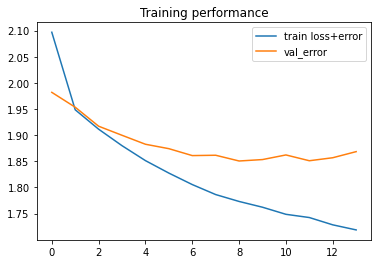

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

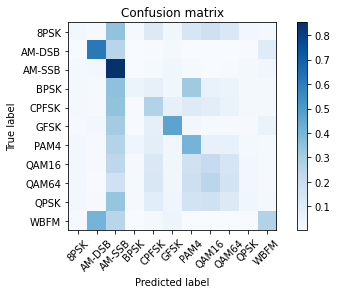

In [21]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08953418027828192


Overall Accuracy:  0.09423135004530353


Overall Accuracy:  0.0924647253077154


Overall Accuracy:  0.11882669859323555


Overall Accuracy:  0.11402203036618042


Overall Accuracy:  0.14342265529841655


Overall Accuracy:  0.18874773139745918


Overall Accuracy:  0.2634457611668186


Overall Accuracy:  0.31323485076876695


Overall Accuracy:  0.37857577601947656


Overall Accuracy:  0.39690402476780184


Overall Accuracy:  0.43678506923540034


Overall Accuracy:  0.43498452012383904


Overall Accuracy:  0.44342226310947563


Overall Accuracy:  0.44423963133640554


Overall Accuracy:  0.42533252720677145


Overall Accuracy:  0.4418816388467375


Overall Accuracy:  0.4282738095238095


Overall Accuracy:  0.4379693601682187


Overall Accuracy:  0.4322757779133618


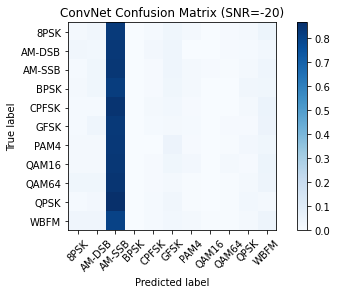

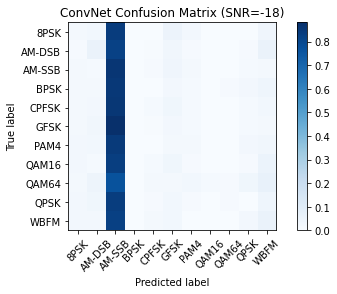

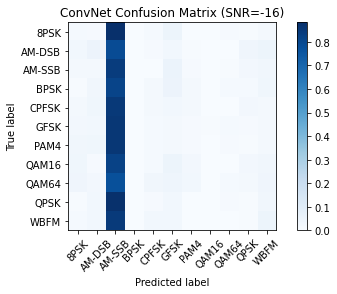

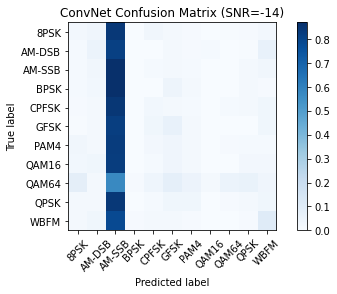

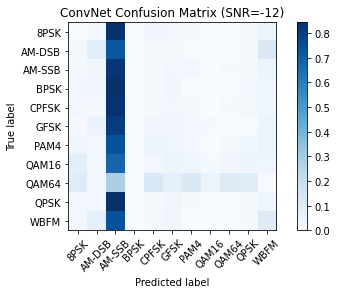

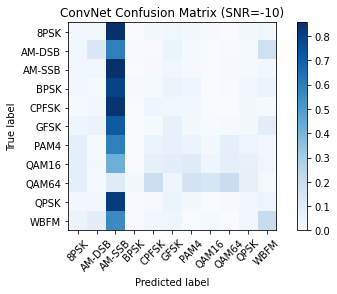

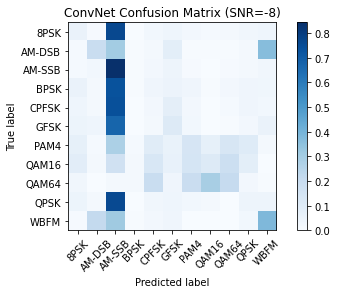

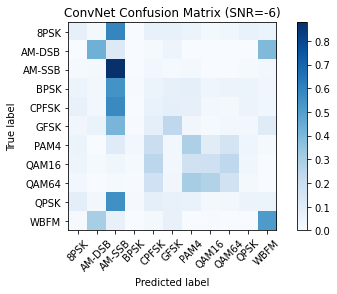

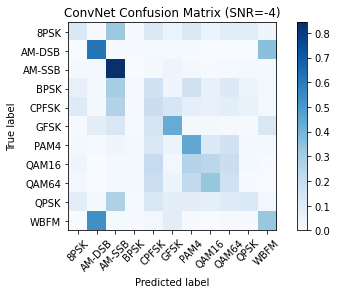

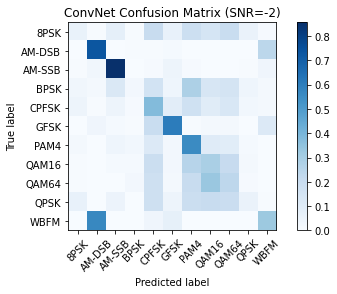

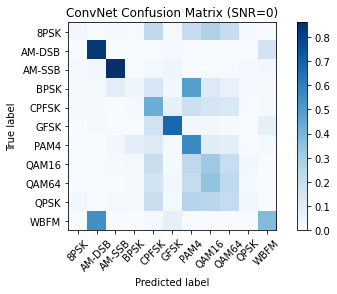

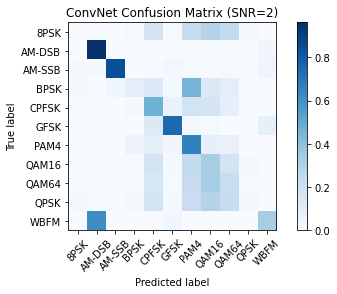

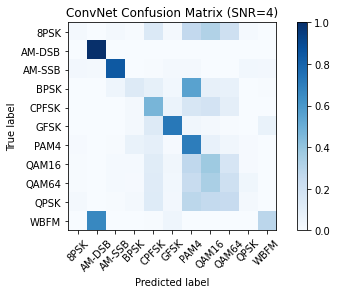

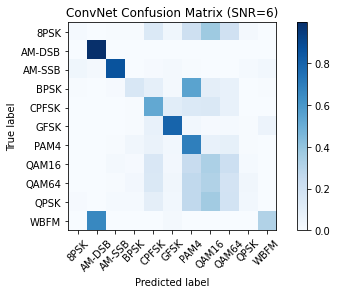

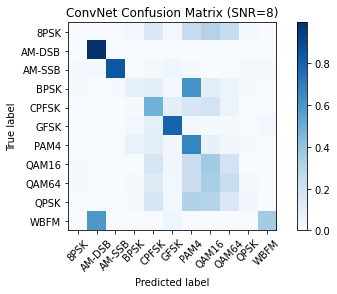

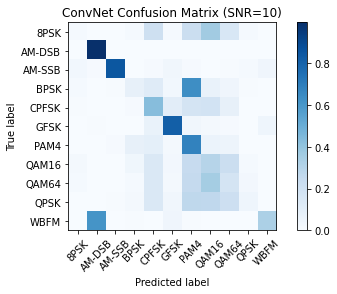

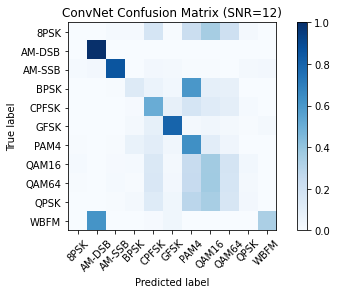

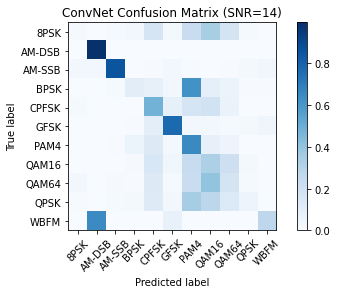

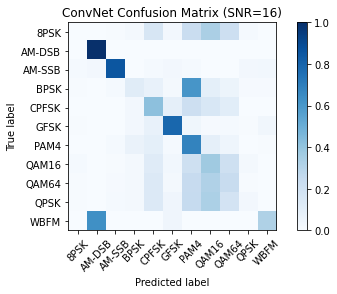

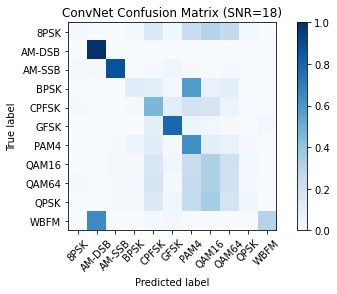

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [23]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,11,11,14,18,26,31,37,39,43,43,44,44,42,44,42,43,43


In [24]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

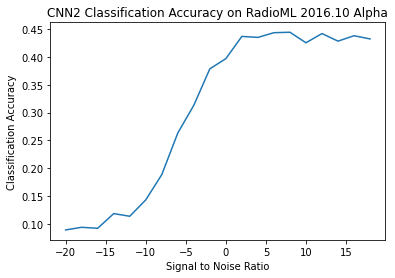

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")